<a href="https://colab.research.google.com/github/isarandi/metrabs/blob/master/metrabs_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MeTRAbs Absolute 3D Human Pose Estimator

István Sárándi, Timm Linder, Kai Oliver Arras, Bastian Leibe: "*MeTRAbs: Metric-Scale Truncation-Robust Heatmaps for Absolute 3D Human Pose Estimation.*"
In IEEE Transactions on Biometrics, Behavior, and Identity Science (T-BIOM), Selected Best Works From Automatic Face and Gesture Recognition (FG) 2020

* https://github.com/isarandi/metrabs
* https://arxiv.org/abs/2007.07227
* https://youtu.be/BemM8-Lx47g

Let's get the model files and a test image.

In [1]:
%%shell
wget -q https://omnomnom.vision.rwth-aachen.de/data/metrabs/metrabs_{multiperson_smpl,multiperson_smpl_combined}.zip -P models
unzip -q 'models/*.zip' -d models
wget -q https://raw.githubusercontent.com/isarandi/metrabs/master/test_image_3dpw.jpg

Archive:  models/metrabs_multiperson_smpl_combined.zip
   creating: models/metrabs_multiperson_smpl_combined/
  inflating: models/metrabs_multiperson_smpl_combined/saved_model.pb  
   creating: models/metrabs_multiperson_smpl_combined/variables/
  inflating: models/metrabs_multiperson_smpl_combined/variables/variables.index  
  inflating: models/metrabs_multiperson_smpl_combined/variables/variables.data-00000-of-00001  
   creating: models/metrabs_multiperson_smpl_combined/assets/

Archive:  models/metrabs_multiperson_smpl.zip
   creating: models/metrabs_multiperson_smpl/
  inflating: models/metrabs_multiperson_smpl/saved_model.pb  
   creating: models/metrabs_multiperson_smpl/variables/
  inflating: models/metrabs_multiperson_smpl/variables/variables.index  
  inflating: models/metrabs_multiperson_smpl/variables/variables.data-00000-of-00001  
   creating: models/metrabs_multiperson_smpl/assets/

2 archives were successfully processed.


## Combined Detector + Pose Estimator
Load the combined detector+pose estimator model and run it on the test image. (Detector credits: https://github.com/hunglc007/tensorflow-yolov4-tflite)

In [4]:
import tensorflow as tf
model = tf.saved_model.load('models/metrabs_multiperson_smpl_combined')
image = tf.image.decode_jpeg(tf.io.read_file('test_image_3dpw.jpg'))
detections, poses3d, poses2d = model.predict_single_image(image)

## Visualize

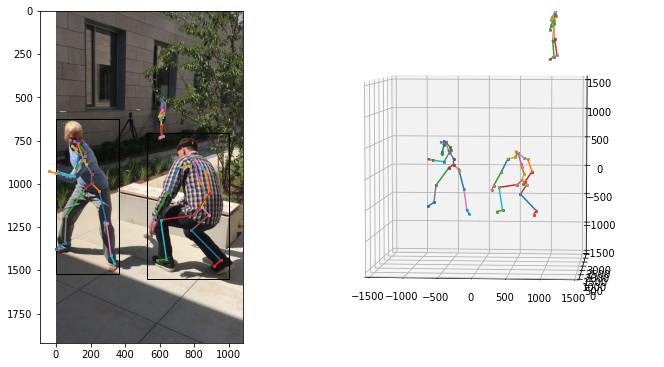

In [6]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D

def visualize(im, detections, poses3d, poses2d, edges):
    fig = plt.figure(figsize=(10, 5.2))
    image_ax = fig.add_subplot(1, 2, 1)
    image_ax.imshow(image)

    for x, y, w, h in detections[:, :4]:
        image_ax.add_patch(Rectangle((x, y), w, h, fill=False))

    for pose2d in poses2d:
        for i_start, i_end in edges:
            image_ax.plot(*zip(pose2d[i_start], pose2d[i_end]), marker='o', markersize=2)
        image_ax.scatter(pose2d[:, 0], pose2d[:, 1], s=2)

    pose_ax = fig.add_subplot(1, 2, 2, projection='3d')
    pose_ax.view_init(5, -85)
    pose_ax.set_xlim3d(-1500, 1500)
    pose_ax.set_zlim3d(-1500, 1500)
    pose_ax.set_ylim3d(0, 3000)

    # Matplotlib plots the Z axis as vertical, but our poses have Y as the vertical axis.
    # Therefore, we do a 90° rotation around the X axis:
    poses3d[..., 1], poses3d[..., 2] = poses3d[..., 2], -poses3d[..., 1]
    for pose3d in poses3d:
        for i_start, i_end in edges:
            pose_ax.plot(*zip(pose3d[i_start], pose3d[i_end]), marker='o', markersize=2)
        pose_ax.scatter(pose3d[:, 0], pose3d[:, 1], pose3d[:, 2], s=2)

    fig.tight_layout()
    plt.show()

visualize(image.numpy(), detections.numpy(), poses3d.numpy(), poses2d.numpy(), model.joint_edges.numpy())

## Advanced Prediction Settings

You use your own intrinsic matrix and the bounding boxes (x_min, y_min, width, height) as follows:

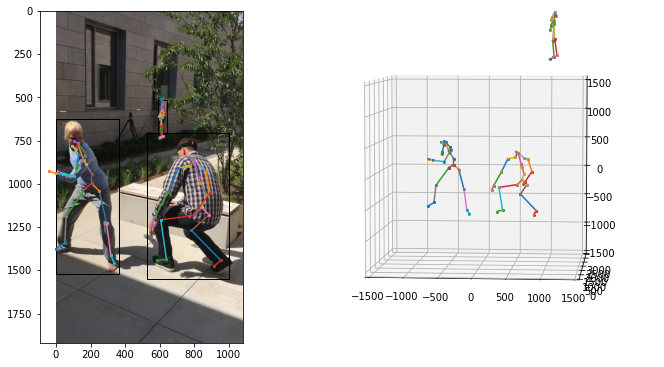

In [7]:
model = tf.saved_model.load('models/metrabs_multiperson_smpl')
intrinsics = tf.constant([[1962, 0, 540], [0, 1969, 960], [0, 0, 1]], dtype=tf.float32)
person_boxes = tf.constant([[0, 626, 367, 896], [524, 707, 475, 841], [588, 512, 54, 198]], tf.float32)

poses3d = model.predict_single_image(image, intrinsics, person_boxes)

# Project the result to 2D
poses2d = tf.einsum('...nk,...jk->...nj', poses3d / poses3d[..., 2:], intrinsics)[..., :2]

visualize(image.numpy(), person_boxes.numpy(), poses3d.numpy(), poses2d.numpy(), model.joint_edges.numpy())